# Understanding the nature of our Quantum Reservoir.

## Datasets

For this study we chose 3 diffrent datasets to test models on. Two synthetic, with known dynamics --- NARMA and Mackey Glassm, and one with unknown ones --- Santa Fe, all typically used in benchmarking Reservoir computing [wringeReservoirComputingBenchmarks2025]. 


based on [wringeReservoirComputingBenchmarks2025]

### NARMA-N

NARMA-N (Nonlinear Auto-Regressive Moving Average):
- imitation task (based on [wringeReservoirComputingBenchmarks2025])
- modeling time series based on Auto-Regressive (AR) and Moving Average (MA) models
- known dynamics: 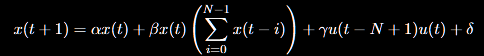
- different N α β γ δ input params in literature
- Can be used for testing non-linear memory capacity --- it could be said that if NARMA-N is learned by model then it has memory capacity of N

### Mackey–Glass
- **Task type:** prediction (based on [wringeReservoirComputingBenchmarks2025])
- **Origin:** derived from a delay differential equation introduced to model physiological systems
- **Biological models:** originally continuous (e.g. breathing rhythms, leukocyte production)
- **Benchmark form:** for reservoir computing we use the discretized, normalized version of the equation
- 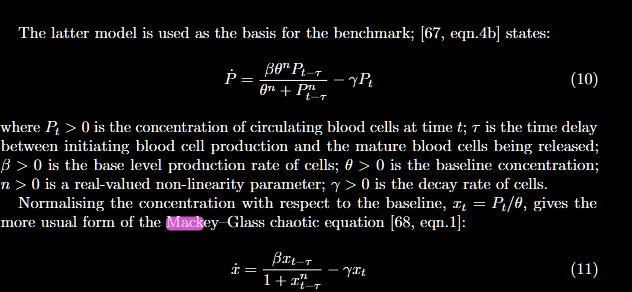
- 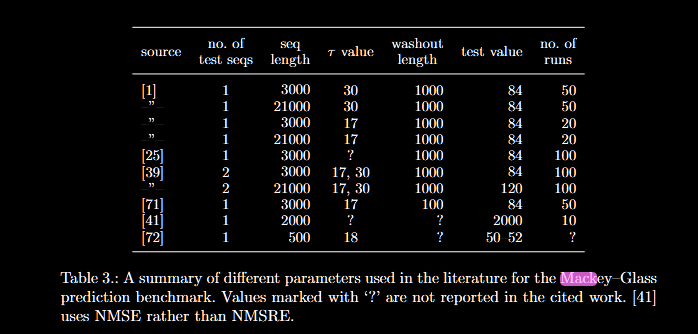


### Santa Fe
- prediction task (based on [wringeReservoirComputingBenchmarks2025])
- unknown dynamics
- produced by trying to achive Lorenz chaos experimentally with lasers
- The original dataset was only 1000 data points long, the shortest of the datasets distributed in the competition. It was also noted for being stationary, low dimensional, clean, scalar-based, and nonlinear. A particularity of the dataset is that the data is characterised by catastrophes: the values grow in a somewhat predictable manner, until one of these catastrophes take place and the values change drastically. See figures 12 and 13.
- 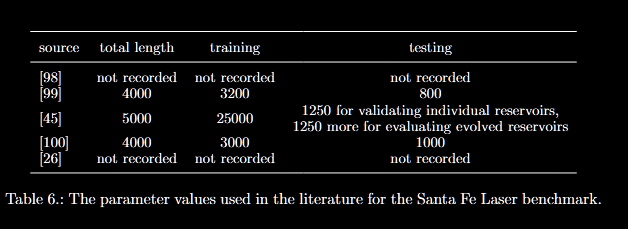
 
## Tasks
3.1.1. Imitation tasks

In an imitation task (see Figure 2), the Reservoir Computer is trained to replicate the dynamics of an open dynamical system, one with inputs. As such, it is given the same time series input as is given to the target dynamical system. This input may, for example, be uniform random noise, such as with NARMA (section 4.1), or a regular frequency signal, such as used in the classic sine wave generation task. The reservoir is then trained to produce the same time series output that the target system produces. The performance of a Reservoir Computer on imitation tasks can be tested in two different ways. The first of these is to measure the error between the reservoir output values and the desired output values. In an imitation task, the desired output values are the output of the dynamical system being imitated. If the dynamical system being imitated is part of a greater whole, such as the control system of a robot, then another adequate test may be, ‘can the trained reservoir adequately replace the target system in situ’ ?

3.1.2. Prediction tasks

In a prediction task, the reservoir imitates a closed dynamical system, one with no inputs. The reservoir must here predict the output of the dynamical system based on the previous output (figure 3). This is useful for learning the behaviour of a dynamical system where the input is unknown, or perhaps does not even exist. However, that is not a requirement. Any dynamical system that can be used for an imitation task can also be used for a prediction task: the only difference is the information input to the reservoir. During training, the reservoir is fed outputs from the target dynamical system as inputs, an the output weights trained to minimise the difference. There are two options during the testing stage. In the driven case, the reservoir is driven with the target outputs as in the training stage. This provides a one-step look-ahead prediction, continually corrected by the actual system outputs to correct for drift. In the freerunning case [25] the reservoir is fed back its own previous output as its next input. This provides a multi-step look-ahead prediction, potentially subject to accumulating errors.

3.1.5. Property measures  Rather than measuring performance on a particular task, some benchmarks instead measure more direct computational properties of the reservoir, such as its memory and generalisation capabilities. The object of these tasks is not to maximise a success rate or minimise an error rate. Instead, we can take these properties and see how the behaviour of the reservoir may make them better suited to different tasks.

# Mackey-Glass

$$
x(t+1) = x(t) + \Delta t \left( \frac{0.2 \, x(t-\tau)}{1 + x(t-\tau)^{10}} - 0.1 \, x(t) \right)
$$

* `tau` → opóźnienie (klasycznie 17)
* `delta_t` → krok czasowy (1 jest najprostszy)
* `length` → ile próbek wygenerować
* `seed` → reproducibility

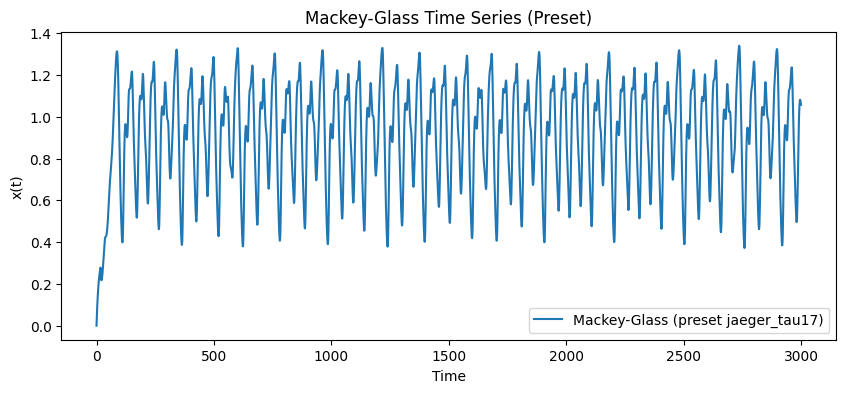

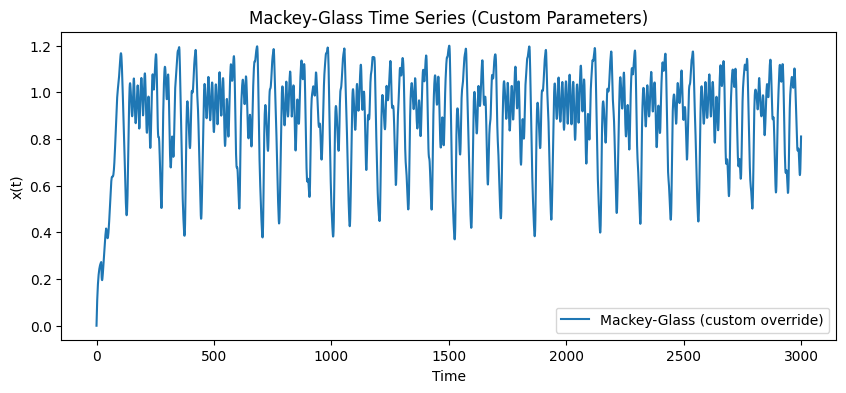

{'length': 3000,
 'seed': 42,
 'series_generated': True,
 'beta': 0.17,
 'gamma': 0.1,
 'n': 10,
 'tau': 30,
 'delta_t': 1.5}

In [1]:
import matplotlib.pyplot as plt
from datasets.mackey_glass import MackeyGlassDataset

# Example 1: use a preset
mg = MackeyGlassDataset(preset="jaeger_tau17")
series = mg.generate()

plt.figure(figsize=(10, 4))
plt.plot(series, label="Mackey-Glass (preset jaeger_tau17)")
plt.xlabel("Time")
plt.ylabel("x(t)")
plt.title("Mackey-Glass Time Series (Preset)")
plt.legend()
plt.show()


# Example 2: custom parameters overriding preset
mg_custom = MackeyGlassDataset(preset="jaeger_tau17", tau=30, beta=0.17, delta_t=1.5)
series_custom = mg_custom.generate()

plt.figure(figsize=(10, 4))
plt.plot(series_custom, label="Mackey-Glass (custom override)")
plt.xlabel("Time")
plt.ylabel("x(t)")
plt.title("Mackey-Glass Time Series (Custom Parameters)")
plt.legend()
plt.show()
mg_custom.info()


In [1]:
# pip install pennylane numpy
import pennylane as qml
from pennylane import numpy as np

# ----------------------------
# 1) Parametry i urządzenie
# ----------------------------
N = 8                 # liczba kubitów (jak w pracy)
layers = 7            # głębokość sprzętowo-efektywnego U_res (Appendix A)
ain = 1e-3            # waga wejścia
afb = 2.0             # siła sprzężenia zwrotnego (stroimy ~ "edge of chaos")
seed = 42
rng = np.random.default_rng(seed)

dev = qml.device("default.qubit", wires=N, shots=None)  # analityczne ⟨Z⟩

# ---------------------------------
# 2) Definicja bramki R_{i,j}(theta)
#    (Eq. (1) w artykule)
# ---------------------------------
def R_ij(i, j, theta):
    qml.CNOT(wires=[i, j])
    qml.RZ(theta, wires=j)
    qml.CNOT(wires=[i, j])
    qml.RX(theta, wires=i)
    qml.RX(theta, wires=j)

# -------------------------------------------------------
# 3) Sprzętowo-efektywna wersja U_res (Appendix A, Fig.7)
# -------------------------------------------------------
def sample_reservoir_params(N, layers, rng):
    # dla każdej warstwy: losujemy typ rotacji (X/Y/Z) i kąt dla każdego kubitu
    rots_kind = []
    rots_theta = []
    for _ in range(layers):
        kinds = rng.integers(0, 3, size=N)     # 0->RX, 1->RY, 2->RZ
        thetas = rng.uniform(0.0, 2*np.pi, size=N)
        rots_kind.append(kinds)
        rots_theta.append(thetas)
    return np.array(rots_kind), np.array(rots_theta)

rots_kind, rots_theta = sample_reservoir_params(N, layers, rng)

def apply_reservoir(N, layers, rots_kind, rots_theta):
    # inicjalna ściana RY(pi/4)
    for w in range(N):
        qml.RY(np.pi/4, wires=w)
    # L warstw: rotacje 1-kubitowe równolegle + drabinka CNOTów
    for l in range(layers):
        for w in range(N):
            k = int(rots_kind[l, w])
            th = rots_theta[l, w]
            if k == 0:   qml.RX(th, wires=w)
            elif k == 1: qml.RY(th, wires=w)
            else:        qml.RZ(th, wires=w)
        # drabinka CNOT: (0,1), (2,3), ... , potem przesunięta (1,2), (3,4), ...
        for start in [0, 1]:
            for a in range(start, N-1, 2):
                qml.CNOT(wires=[a, a+1])

# -------------------------------------------------------
# 4) Mapowanie sprzężenia zwrotnego z z_{k-1} na pary (i,j)
#    (na rys. 2 feedback idzie na kubity 3..8; tu wybieramy
#    stałe, gęste mapowanie – dowolne stałe mapowanie jest OK)
# -------------------------------------------------------
# Dla przejrzystości: wejście kodujemy na (0,1); feedback na zestaw par
feedback_pairs = [(2,3),(3,4),(4,5),(5,6),(6,7),(7,2),(0,2),(1,3)]  # 8 komponentów z_prev

# -------------------------------------------------------
# 5) Jeden cykl: s_k + z_{k-1} -> z_k
# -------------------------------------------------------
@qml.qnode(dev)
def qrc_cycle(s_k, z_prev, ain, afb, rots_kind, rots_theta):
    # start w |0>^N
    # (default.qubit resetuje stan do |0>^N dla każdego wywołania QNode)

    # (i) wejście sk na kubity (0,1)
    R_ij(0, 1, ain * s_k)

    # (ii) feedback z_{k-1} rozlany po parach
    #     (wartości z_prev zakładamy w [-1,1], jak ⟨Z⟩)
    for alpha, (i,j) in enumerate(feedback_pairs):
        theta = afb * z_prev[alpha]
        R_ij(i, j, theta)

    # (iii) rezerwuar: splątanie i skramblowanie
    apply_reservoir(N, layers, rots_kind, rots_theta)

    # (iv) pomiar Z na wszystkich kubitach → wektor z_k
    return [qml.expval(qml.PauliZ(w)) for w in range(N)]

# -------------------------------------------------------
# 6) Pętla po sekwencji, trening i predykcja
# -------------------------------------------------------
def run_qrc(sequence, ain=ain, afb=afb,
            warmup=500, ltr=2000, lts=2000):
    L = len(sequence)
    assert L >= warmup + ltr + lts

    # z_0: wektor losowy (Sec. II.B)
    z_prev = rng.uniform(0.0, 1.0, size=N)

    Z_all = np.zeros((L, N))
    for k in range(L):
        z_k = np.array(qrc_cycle(sequence[k], z_prev, ain, afb, rots_kind, rots_theta), dtype=float)
        Z_all[k] = z_k
        z_prev = z_k  # online feedback

    # Macierze projektorów do regresji liniowej (Sec. II.B)
    # X = [z_k, 1]  (stała kolumna biasu)
    def make_X(Z_slice):
        ones = np.ones((Z_slice.shape[0], 1))
        return np.hstack([Z_slice, ones])

    X_tr = make_X(Z_all[warmup:warmup+ltr])
    X_ts = make_X(Z_all[warmup+ltr:warmup+ltr+lts])

    return X_tr, X_ts

# ----------------------------
# 7) Przykład użycia (STM / predykcja):
# ----------------------------
# a) Zadanie pamięci krótkoterminowej (STM): target y_k = s_{k-d}
# b) Albo dowolny inny target (np. k-step ahead)
L = 5000
s = rng.uniform(0.0, 1.0, size=L)   # losowy sygnał wejściowy jak w pracy

X_tr, X_ts = run_qrc(s, ain=ain, afb=afb, warmup=500, ltr=2000, lts=2000)

# STM z opóźnieniem d:
d = 4
y_tr = s[500-d : 500+2000-d]
y_ts = s[500+2000-d : 500+2000+2000-d]

# Uczenie tylko wag wyjścia (Moore–Penrose)
w = np.linalg.pinv(X_tr) @ y_tr
y_hat = X_ts @ w

# R^2 / NMSE itp.
def r2(y, yhat):
    num = np.sum((y - yhat)**2)
    den = np.sum((y - np.mean(y))**2) + 1e-12
    return 1.0 - num/den

print("R^2 (test):", float(r2(y_ts, y_hat)))


R^2 (test): 0.9978158289253916


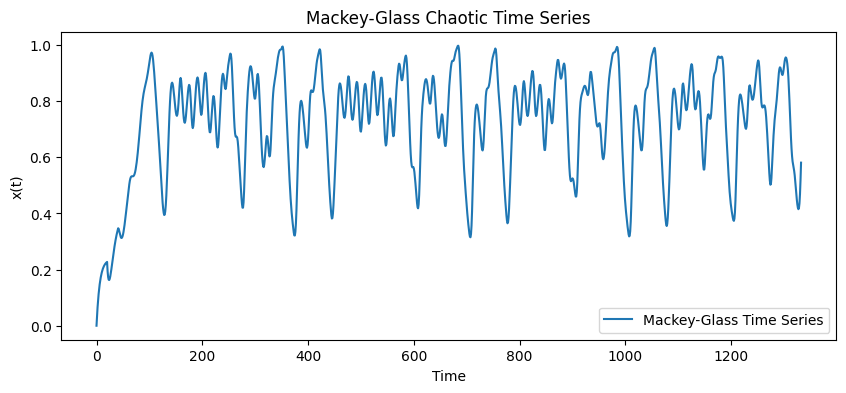

In [5]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
#   As the result will be generated from quantum measurement, we need to scale it to [0..1]
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    x_min, x_max = np.min(x), np.max(x)
    x = (x - x_min) / (x_max - x_min)

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
# time_series = mackey_glass(dt=1, T=2000)
time_series = mackey_glass(beta=0.17, dt=1.5, T=2000, tau=30)

plt.figure(figsize=(10, 4))
plt.plot(time_series, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

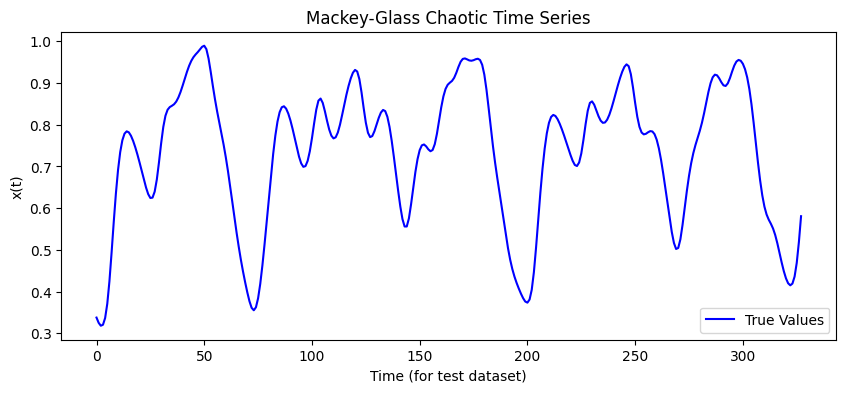

In [6]:
### Prepare the data, scale to [0..1]
def create_io_pairs(data, window_size):
    """
    Create input-output pairs for training/testing.
    """
    inputs = []
    outputs = []
    for i in range(len(data) - window_size):
        inputs.append(data[i:i + window_size])
        outputs.append(data[i + window_size])
    return np.array(inputs), np.array(outputs)

### Data settings
window_size = 5 # 10  # Use the last ws time steps to predict the next step
train_size = 1000  # Use the first trs points for training
test_size = 500   # Use the next tst points for testing

### Create data
train_inputs, train_outputs = create_io_pairs(time_series[:train_size], window_size)
test_inputs, test_outputs = create_io_pairs(time_series[train_size:train_size + test_size], window_size)

### Plot the test set
plt.figure(figsize=(10, 4))
plt.plot(test_outputs, label="True Values", color="blue")
plt.xlabel('Time (for test dataset)')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

In [8]:
import pennylane as qml

from pennylane import numpy as np
import matplotlib.pyplot as plt

In [9]:
### Quantum reservoir hyper-parameters
n_qubits = window_size  # Number of qubits in the reservoir
n_layers = 1  # Number of layers in the quantum circuit
seed = 2025   # Random seed used throughout

### Quantum device to use
dev = qml.device("default.qubit", wires=n_qubits, seed=seed)

In [10]:
@qml.qnode(dev)
def quantum_feature_map(inputs, weights, biases, n_layers=1, n_qubits=4):
    """
    Quantum circuit that acts as a feature map.
    Its only job is to encode the current classical state into
    multidimensional quantum features.
    
    Args:
        inputs: The current classical state of the ESN.
        weights: Reservoir weights (fixed).
        biases: Input biases (fixed).
    Returns:
        objservables: Quantum features
    """
    # Encode the classical input into the quantum state vector
    for i in range(n_qubits):
        total_angle = inputs[i] + biases[i]
        qml.RX(total_angle, wires=i)

    # Reservoir dynamics (fixed weights)
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.Rot(*weights[layer, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Return quantum features (observables)
    return [qml.expval(qml.PauliX(i)) for i in range(n_qubits)] + \
           [qml.expval(qml.PauliY(i)) for i in range(n_qubits)] + \
           [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [11]:
### The ESN-based training function, which has the following steps:
#   1. Compute the sequence of classical reservoir states
#   2. Map these classical states to quantum features
#   3. Train the readout layer using ridge regression

def train_esn_reservoir(train_inputs, train_outputs, n_layers=1, n_qubits=4, leakage_rate=0.1, lambda_reg=1e-6):
    """
    Trains a quantum reservoir using a classical Echo State Network for memory.
    
    Args:
        train_inputs: Training input data (shape [n_samples, n_features]).
        train_outputs: Target values (shape [n_samples]).
        n_layers: Number of reservoir layers.
        n_qubits: Number of qubits.
        leakage_rate (α): Controls the ESN's memory retention.
        lambda_reg: Ridge regression parameter.      
    Returns:
        W_out: Readout weights.
        weights: Reservoir weights.
        biases: Input biases.
    """
    # Initialize parameters (these are fixed for the reservoir)
    weights = np.random.uniform(-np.pi, np.pi, (n_layers, n_qubits, 3))
    biases = np.random.uniform(-0.5, 0.5, n_qubits)
    n_observables = 3 * n_qubits
    n_samples = len(train_inputs)

    # 1. Compute the classical ESN states
    classical_states = np.zeros((n_samples, n_qubits))
    current_classical_state = np.zeros(n_qubits)

    # Update classical state using the ESN rule
    for t in range(n_samples):
        # The ESN state update equation
        # Note: We broadcast the scalar input across the state vector
        current_classical_state = \
            (1 - leakage_rate) * current_classical_state + \
            leakage_rate * train_inputs[t]
        classical_states[t] = current_classical_state

    # 2. Map classical states to quantum features
    quantum_features = np.zeros((n_samples, n_observables))
    for t in range(n_samples):
        quantum_features[t] = quantum_feature_map(
            inputs=classical_states[t], weights=weights, biases=biases,
            n_layers=n_layers, n_qubits=n_qubits
        )
    
    # 3. Train the readout layer using Ridge regression
    R = quantum_features
    Y = train_outputs.reshape(-1, 1)
    I = np.eye(n_observables)
    W_out = np.linalg.solve(R.T @ R + lambda_reg * I, R.T @ Y).flatten()
    
    return W_out, weights, biases

In [12]:
### The ESN-based prediction function.
#   It simulates the ESN state evolution and uses the quantum feature map
#   at each time step to make its prediction.

def predict_esn(test_inputs, weights, biases, W_out, n_layers=1, n_qubits=4, leakage_rate=0.1):
    """
    Makes predictions using the trained ESN-Quantum Reservoir model.
    
    Args:
        test_inputs: Test input data (shape [n_samples, n_features]).
        weights: Reservoir weights.
        biases: Input biases.
        W_out: Readout weights.
        leakage_rate (gamma): Controls the ESN's memory retention.
    Returns:
        predictions: Target test values (shape [n_samples]).
    """
    # Initialize predictoins and the classical state
    predictions = [] 
    current_classical_state = np.zeros(n_qubits)

    for input_val in test_inputs:
        
        # Update classical state using the ESN rule
        current_classical_state = \
            (1 - leakage_rate) * current_classical_state + \
            leakage_rate * input_val
        
        # Get quantum features for the current classical state
        q_features = quantum_feature_map(
            inputs=current_classical_state, weights=weights, biases=biases,
            n_layers=n_layers, n_qubits=n_qubits 
        )
        
        # Predict using the trained readout weights
        y_pred = np.dot(W_out, q_features)
        predictions.append(y_pred)
        
    return np.array(predictions)

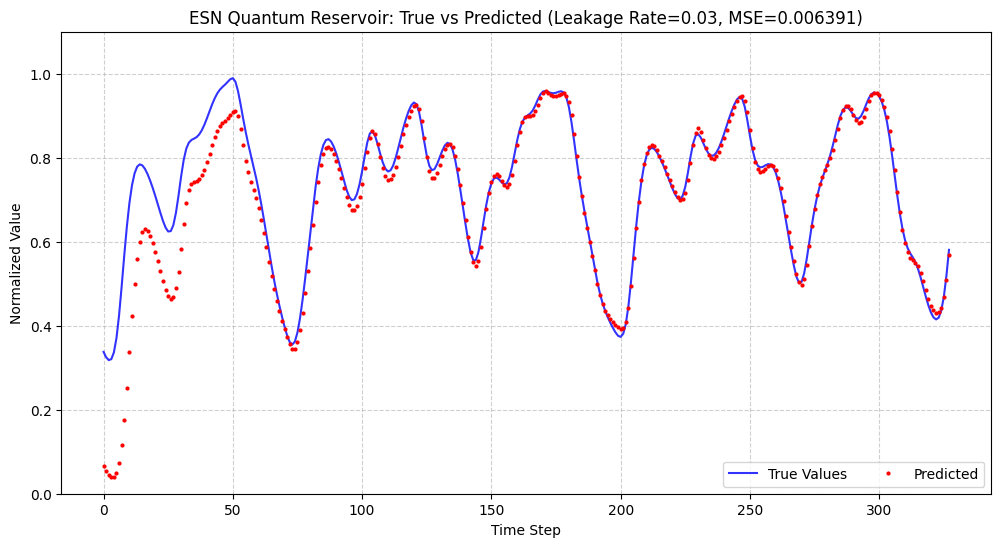

In [13]:
### Conduct a single test

# For reproducibility
np.random.seed(seed)

# Select leakage rate which relies on memory
test_leakage = 0.03

# Create the reservoir and train it
W_out, weights, biases = train_esn_reservoir(
    train_inputs, 
    train_outputs, 
    n_layers=n_layers, 
    n_qubits=n_qubits,
    leakage_rate=test_leakage
)

# Predict test targets
test_preds = predict_esn(test_inputs, weights, biases, W_out, 
                         n_layers=n_layers, n_qubits=n_qubits, leakage_rate=test_leakage)
mse = np.mean((test_preds - test_outputs)**2)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_outputs, label="True Values", color="blue", alpha=0.8)
plt.plot(test_preds, label="Predicted", color="red", linestyle="", marker='.', markersize=4)
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.ylim(0, 1.1)
plt.title(f'ESN Quantum Reservoir: True vs Predicted (Leakage Rate={test_leakage}, MSE={mse:0.6f})')
plt.legend(loc='lower right', ncol=2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [17]:
from datasets.mackey_glass import MackeyGlassDataset

mg = MackeyGlassDataset(preset="jaeger_tau17", length=6000, seed=42)
series = mg.generate()

# Normalizacja [0,1] dla spójności
s = (series - series.min()) / (series.max() - series.min())


In [18]:
warmup, ltr, lts = 500, 2000, 2000
train_inputs = s[warmup : warmup+ltr]
train_outputs = s[warmup-4 : warmup+ltr-4]   # STM z opóźnieniem d=4
test_inputs  = s[warmup+ltr : warmup+ltr+lts]
test_outputs = s[warmup+ltr-4 : warmup+ltr+lts-4]


In [19]:
X_tr, X_ts = run_qrc(s, ain=1e-3, afb=2.0, warmup=warmup, ltr=ltr, lts=lts)

# Regresja (uczenie tylko readoutu)
w = np.linalg.pinv(X_tr) @ train_outputs
y_hat_qrc = X_ts @ w


In [20]:
W_out, weights, biases = train_esn_reservoir(
    train_inputs.reshape(-1,1), 
    train_outputs, 
    n_layers=1, 
    n_qubits=4,
    leakage_rate=0.03
)

test_preds_qesn = predict_esn(
    test_inputs.reshape(-1,1), 
    weights, biases, W_out,
    n_layers=1, n_qubits=4, leakage_rate=0.03
)


In [21]:
def r2(y, yhat):
    return 1.0 - np.sum((y - yhat)**2) / (np.sum((y - np.mean(y))**2) + 1e-12)

print("QRC (PRX style) R²:", r2(test_outputs, y_hat_qrc))
print("QESN (hybrid)   R²:", r2(test_outputs, test_preds_qesn))


QRC (PRX style) R²: 0.9999978973128628
QESN (hybrid)   R²: 0.3445886962044459


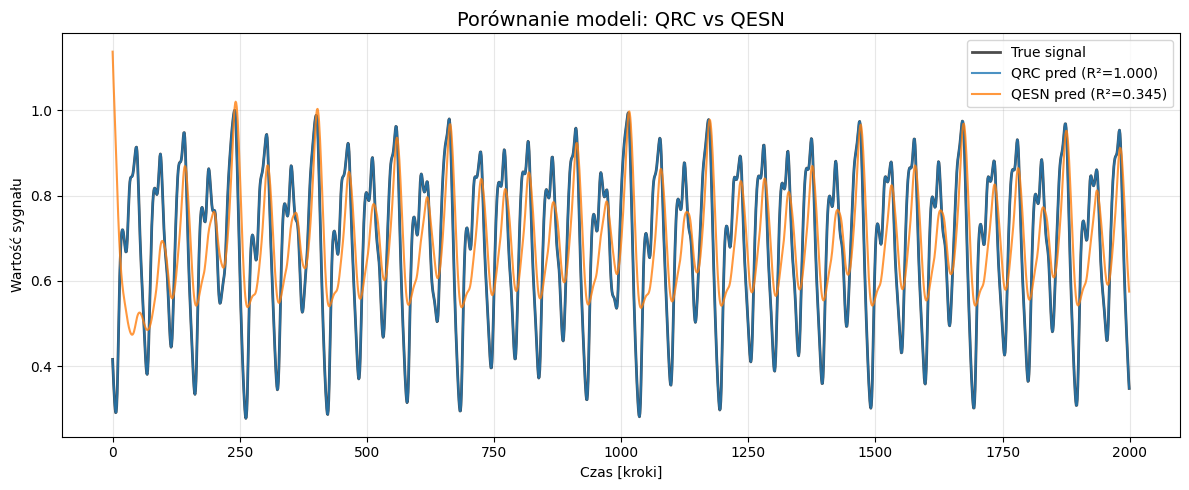

In [22]:
# --- Wykres ---
plt.figure(figsize=(12, 5))

# Prawdziwe dane
plt.plot(test_outputs, label="True signal", color="black", linewidth=2, alpha=0.7)

# Predykcja QRC
plt.plot(y_hat_qrc, label=f"QRC pred (R²={r2(test_outputs, y_hat_qrc):.3f})", alpha=0.8)

# Predykcja QESN
plt.plot(test_preds_qesn, label=f"QESN pred (R²={r2(test_outputs, test_preds_qesn):.3f})", alpha=0.8)

plt.title("Porównanie modeli: QRC vs QESN", fontsize=14)
plt.xlabel("Czas [kroki]")
plt.ylabel("Wartość sygnału")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()